# 1. Importowanie bibliotek i podstawowe przygotowanie danych

In [1]:
from src.data.datareader import CleanedDataReader
from src.data.utils import create_group_id, drop_duplicates, dropna, prepare_target_and_weights
from src.features.sampling import split_data_by_group_and_stratify
from src.models.scoring import evaluate_models, plot_lorenz_curves, plot_feature_importances
from src.data.utils import prepare_target_and_weights

In [2]:
data_reader = CleanedDataReader(path='../../data/raw/claims_data.csv')
df = data_reader.get_enhanced_data(index_col=0)

df = dropna(df, subset=['ClaimNb', 'Exposure'])
df = drop_duplicates(df, subset=['IDpol'])
df = create_group_id(df)
df = df.assign(ClaimNb=lambda x: x.ClaimNb.clip(upper=4)).assign(Exposure=lambda x: x.Exposure.clip(upper=1))

train, test = split_data_by_group_and_stratify(df)
y_train, weights_train, y_freq_train, y_test, weights_test, y_freq_test = prepare_target_and_weights(train, test)

Bad line:
['653', '1357.0', '1.0', '0.01', 'E', '7.0', '0.0', '41.0', '80.0', 'B12', 'Diesel', '6257.0', 'R93', '']
was converted to:
['653', '1357.0', '1.0', '0.01', 'E', '7.0', '0.0', '41.0', '80.0', 'B12', 'Diesel', '6257.0', 'R93']

Bad line:
['1435', '2967.0', '1.0', '0.64', 'B', '5.0', '0.0', '53.0', '50.0', 'B12', '', 'Regular', '68.0', 'R52']
was converted to:
['1435', '2967.0', '1.0', '0.64', 'B', '5.0', '0.0', '53.0', '50.0', 'B12', 'Regular', '68.0', 'R52']

Bad line:
['123123', '1070775.0', '0.0', '0.48', 'B', '8.0', '7.0', '42.0', '59.0', 'B2', 'Diesel', '72.0', 'R52', '']
was converted to:
['123123', '1070775.0', '0.0', '0.48', 'B', '8.0', '7.0', '42.0', '59.0', 'B2', 'Diesel', '72.0', 'R52']

Bad line:
['381011', '3043346.0', '0.0', '0.92', 'A', '4.0', '2.0', '60.0', '90.0', 'B12', '', 'Regular', '6.0', 'R72']
was converted to:
['381011', '3043346.0', '0.0', '0.92', 'A', '4.0', '2.0', '60.0', '90.0', 'B12', 'Regular', '6.0', 'R72']

Bad line:
['547534', '4138712.0', '1.0

# 2. Importowanie modeli

In [3]:
model_stats = evaluate_models(train, y_freq_train, test, y_freq_test, weights_train, weights_test)

Found 15 models:
  - glm_10t_tuned_pipeline
  - glm_200t_tuned_pipeline
  - glm_based
  - xgboost_10t_pipeline
  - xgboost_10t_simple_pipeline
  - xgboost_1t_pipeline
  - xgboost_1t_pipeline_best_from_glm_tuned
  - xgboost_1t_simple_pipeline
  - xgboost_20t_pipeline
  - xgboost_20t_simple_pipeline
  - xgboost_30t_pipeline
  - xgboost_30t_simple_pipeline
  - xgboost_5t_pipeline
  - xgboost_5t_pipeline_best_from_glm_tuned
  - xgboost_5t_simple_pipeline


# 3. Wybór najlepszego modelu
W oparciu o poprawę Poisson Deviance (vs model bazowy / DummyRegressor) i indeks Giniego

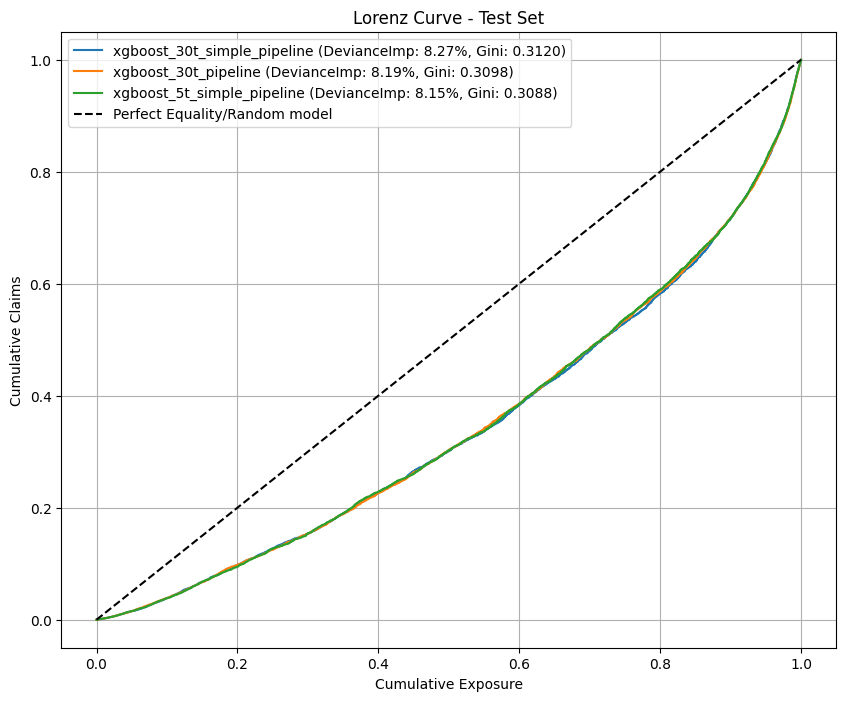

In [4]:
plot_lorenz_curves(model_stats)

In [5]:
best_model = model_stats.sort_values(by=['GiniCoefficientTest', 'ImprovementDevianceTest'], ascending=False).head(1).pipeline.iloc[0]

## Feature importance najlepszego modelu
Korzystam z faktu, że najlepszym mod

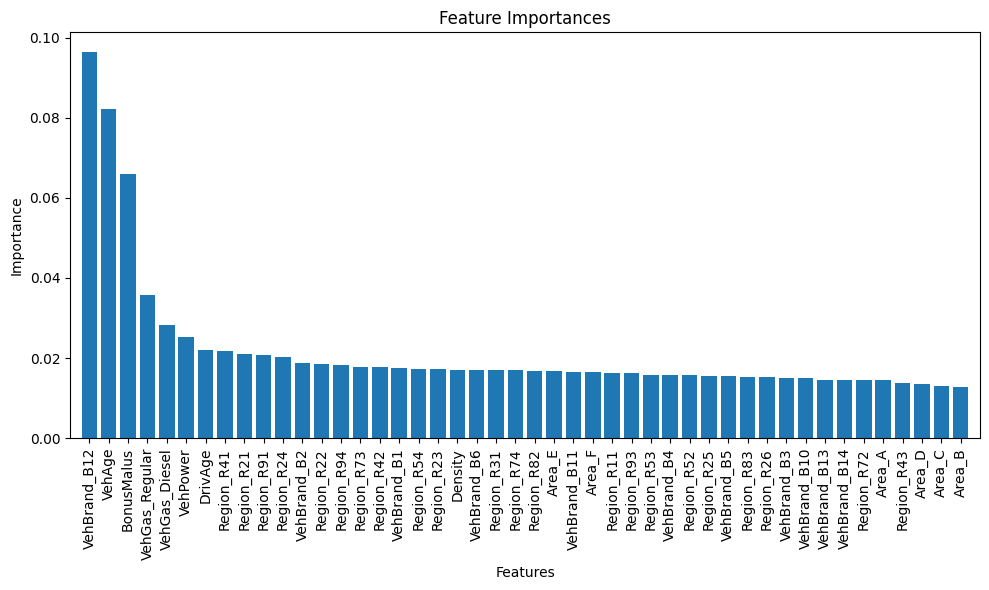

In [6]:
plot_feature_importances(best_model)

## Feature importance - model agnostic approach

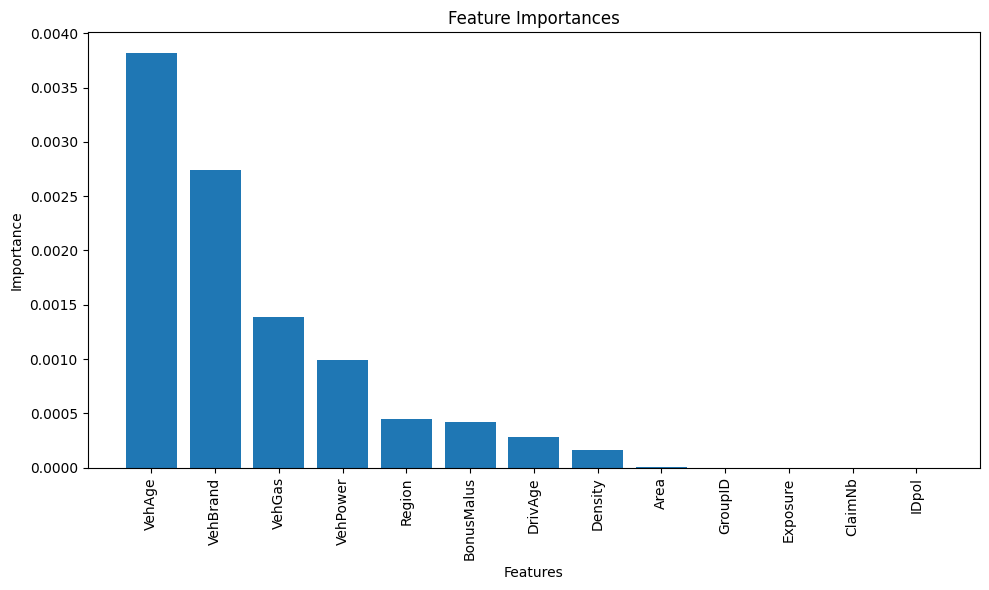

In [7]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, test, y_freq_test, n_repeats=10, random_state=0)
plot_feature_importances(feature_names=test.columns, importances=result.importances_mean)